In [1]:
import pandas as pd
import prototype_for_notebooks as pt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

c:\users\kobyl\anaconda3\envs\anomaly\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
path_to_data = 'D:\\ubuntu\\zephyr_data\\'

In [5]:
import hashlib

def saveSnippetIntoFile(snippet):
    m = hashlib.sha256()
    m.update(snippet.encode('utf-8'))
    snippet_filename = m.hexdigest() + '.py'
    path_to_file = 'complex_exp_snippets_files\\' + snippet_filename
    
    with open(path_to_data + path_to_file, 'w', encoding='utf-8') as f:
        f.write(snippet)
        f.close()
    return path_to_file

# Вычисление A-индекса

Для случайной подвыборки кода длины 10000 вычислим А-индекс.

In [8]:
import pickle5 as pickle

pickle_file = open(path_to_data + 'complex_exp_code\\complex_exp_code.pickle','rb')
data = pickle.load(pickle_file)

In [9]:
data['path_to_file'] = data['snippet source code'].apply(saveSnippetIntoFile)

In [10]:
anomaly_results = pd.DataFrame.from_records([(item[3], item[0][22:], item[4])
                                            for item in pt.calc_anomalies(pt.get_python_paths(path_to_data + 'complex_exp_snippets_files\\'))], 
                                            columns =['a-index', 'path_to_file', 'message'])
df = data.join(anomaly_results.set_index('path_to_file'), on='path_to_file')

# Связь сложности выражений и А-индекса

Посмотрим на коррелированность числа операндов в выражениях и А-индекса.

In [11]:
df.loc[df['num_statements'] > 0, ['num_statements', 'a-index']].corr(method='spearman')

,num_statements,a-index
num_statements,1.000000,-0.163115
a-index,-0.163115,1.000000


In [13]:
import seaborn as sb
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='num_statements', ylabel='a-index'>

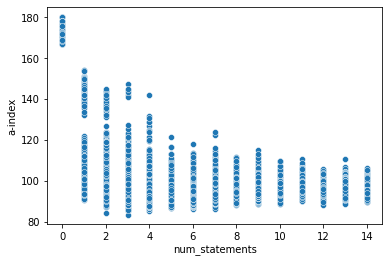

In [14]:
sb.scatterplot(x='num_statements',
               y='a-index',
               data=df)

<AxesSubplot:xlabel='num_statements', ylabel='cc'>

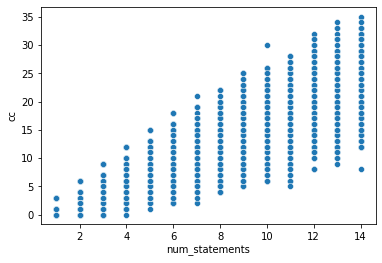

In [34]:
sb.scatterplot(x='num_statements',
               y='cc',
               data=df)

# Анализ связи А-индекса с частотой часто встречающихся токенов

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [ ]:
from collections import Counter

df['max_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x.most_common(1)[0][1])
df['max_G_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x['Ġ'])

Подсчитаем корреляции частот часто встречающихся токенов с А-индексом.

In [ ]:
df[['a-index', 'max_token_occurence', 'max_G_token_occurence']].corr(method='spearman')

Построим диаграмму рассеяния.

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df)

Уберем выбросы и снова построим

In [ ]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)])

Подсчитаем корреляцию.

In [ ]:
df.loc[(df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)) &
       (df['max_G_token_occurence'] > 10), 
       ['max_G_token_occurence', 'a-index']].corr(method='spearman')

# Анализ связи А-индекса с частотой подряд идущих токенов

Напишем функции для вычисления наибольших частот подряд идущих токенов.

In [ ]:
from itertools import groupby

def computeMaxRepetitiveTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    return sorted(token_occurences, key=lambda x: x[1])[-1][1]

In [ ]:
def computeMaxRepetitiveGTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    
    max_count = 0
    for token, count in sorted(token_occurences, key=lambda x: x[1]):
        if token == 'Ġ':
            max_count = max(max_count, count)    
    return max_count

Вычислим эти частоты.

In [ ]:
df['max_consequtive_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveTokenSequenceLength)
df['max_consequtive_G_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveGTokenSequenceLength)

Подсчитаем корреляции.

In [ ]:
df[['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

Посмотрим на графики

In [ ]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df);

# Выводы

- частоты символа G слабо коррелированы с А-индексом;.

# Анализ связи А-индекса с некоторыми метриками кода

In [15]:
from radon.visitors import ComplexityVisitor
from radon.complexity import cc_rank
from radon.metrics import h_visit, mi_visit
from radon.raw import analyze
import numpy as np

In [21]:
import re

def checkExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    if number_of_spaces_to_remove > 0:
        return True

In [22]:
def removeExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    return '\n'.join([snippet_line[number_of_spaces_to_remove:] 
                      for snippet_line in snippet.split('\n')])

In [23]:
def refineSnippet(snippet):
    try:
        ComplexityVisitor.from_code(snippet)
        return snippet
    except:
        try:
            snippet_with_removed_extra_spaces = removeExtraSpaces(snippet)
            ComplexityVisitor.from_code(snippet_with_removed_extra_spaces)
            return snippet_with_removed_extra_spaces
        except:
            return np.nan

In [24]:
def compileSourceCode(snippet,
                      print_snippet=False):
    try:
        compile(snippet.strip(), 'file', 'exec')
        return True
    except SyntaxError as e:
        if ('no binding' not in e.msg) and ('unexpected indent' not in e.msg) and ('unindent' not in e.msg):
            print(e)
            if print_snippet:
                print(snippet)
            return False
        else:
            return True

Предобработка кода: удаление лишних пробелов и синтаксически некорректного кода.

In [26]:
df.columns

Index(['snippet source code', 'num_expr_terms', 'num_statements',
       'path_to_file', 'a-index', 'message'],
      dtype='object')

In [31]:
df = df.loc[df['snippet source code'].notna()]
df['syntax_correct'] = df['snippet source code'].apply(compileSourceCode)
df = df.loc[df['syntax_correct']]

Функции вычисления метрик

In [32]:
def computeCyclomaticComplexity(snippet):
    return ComplexityVisitor.from_code(snippet).functions_complexity

In [17]:
def computeHastadMetrics(snippet):
    hastad_metrics = h_visit(snippet).total
    return {metric:getattr(hastad_metrics, metric) for metric in dir(hastad_metrics) 
            if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}

In [18]:
def computeRawMetrics(snippet):
    try:
        raw_metrics = analyze(snippet)
        return {metric:getattr(raw_metrics, metric) for metric in dir(raw_metrics) 
                if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}
    except SyntaxError:
        return None

In [19]:
def computeMIindex(snippet):
    try:
        return mi_visit(snippet, multi=False)
    except SyntaxError:
        return np.nan

# Подсчет метрик

## Цикломатическая сложность

In [33]:
df['cc'] = df['snippet source code'].apply(computeCyclomaticComplexity)

## Метрики Хастада

In [ ]:
hastad_metrics = df['snippet source code'].apply(computeHastadMetrics)

In [ ]:
for col in hastad_metrics.loc[0].keys():
    df[col] = hastad_metrics.apply(lambda x: x[col])

## Сырые метрики

In [ ]:
raw_metrics = df['snippet source code'].apply(computeRawMetrics)

In [ ]:
for col in raw_metrics.loc[0].keys():
    df[col] = raw_metrics.apply(lambda x: x[col] if x else np.nan)

## Индекс качества кода

In [ ]:
df['MI'] = df['snippet source code'].apply(computeMIindex)

# Связь с метриками

Формируем список всех метрик.

In [ ]:
metric_names = ['cc', 'N1', 'N2', 'bugs', 'calculated_length', 'difficulty',
                'effort', 'h1', 'h2', 'length', 'time', 'vocabulary', 
                'volume', 'blank', 'comments', 'lloc', 'loc', 'multi',
                'single_comments', 'sloc', 'MI']

In [ ]:
pd.set_option('display.max_columns', 500)

Подсчитаем корреляции

In [ ]:
df[metric_names + ['a-index']].corr(method='spearman').round(2)

Вычислим медианные значения А-индекса при фиксированном значении метрик:

In [ ]:
def groupedTargetMedian(data, 
                        feature_name, 
                        feature_value,
                        feature_std,
                        target_name):
    return data.loc[(data[feature_name] > feature_value - 0.1 * feature_std) &
                    (data[feature_name] < feature_value + 0.1 * feature_std), target_name].median(axis=0)

In [ ]:
stds = df[metric_names].std(axis=0)

for metric_name in metric_names:
    df['a-index median given ' + metric_name + ' value'] = df[metric_name].apply(lambda x: 
                                                                                 groupedTargetMedian(df,
                                                                                                     metric_name,
                                                                                                     x,
                                                                                                     stds[metric_name],
                                                                                                     'a-index'))

Функция рисования графиков.

In [ ]:
def plotScatterPlots(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.scatterplot(x=var_name, y='a-index', data=data)
            sb.scatterplot(x=var_name, y='a-index median given ' + var_name + ' value', data=data)
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показаны диаграммы рассеяния между А-индексом и метрикой, а также между медианой А-индекса и метрикой. Для более явной картины убрали выбросы.

In [ ]:
df.loc[df['N1'] <= 100].shape[0] / df.shape[0] * 100

In [ ]:
plotScatterPlots(df.loc[df['N1'] <= 100], metric_names)

In [ ]:
def plotHistograms(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.histplot(x=var_name, data=data, bins=100,
                        stat='count')
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

In [ ]:
plotHistograms(df.loc[df['N1'] <= 100], metric_names);

# Выводы

- для малых значений метрик (кроме MI) А-индекс уменьшается с ростом значений метрик, а потом для достаточно больших значений он растет в ответ на увеличение значений метрик. Для некоторых метрик поведение немонотонное для больших значений метрик.

# Анализ распределения А-индекса

In [ ]:
sb.histplot(x='a-index', data=df);

In [ ]:
sb.histplot(x='max_consequtive_G_token_occurence', data=df);

# Анализ распределения А-индекса для короткого кода

In [ ]:
sb.histplot(x='a-index', data=df.loc[df['loc'] <=4], label='короткий код', color='r');
sb.histplot(x='a-index', data=df, label='весь код', color='g');
plt.legend();

Вмдно что короткий код имеет более высокий А-индекс.

In [ ]:
sb.scatterplot(x='num_expr_terms',
               y='h2',
               data=df)

Сложность выражения тесно связана с метрикой числа операндов.